# Third version: FP16, larger batch, training and validation losses plotted

We also disable the gradient acc as it doesn't mix well with FP16.  
Thanks to the plot, we see that early stopping works correctly.  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir "/content/drive/MyDrive/roberta-checkpoints-3"
!mkdir "/content/drive/MyDrive/roberta-checkpoints-3/results/"

mkdir: cannot create directory ‘/content/drive/MyDrive/roberta-checkpoints-3’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/roberta-checkpoints-3/results/’: File exists


In [3]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
from transformers import EarlyStoppingCallback


# Check if a GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the dataset
dataset = load_dataset("imdb")

# Split the dataset into training and validation sets
train_dataset = dataset["train"]
val_dataset = dataset["test"]

# Load the pre-trained RoBERTa tokenizer and model
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

# Define the function to tokenize the input text and convert it to PyTorch tensors
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Preprocess the training and validation datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

output_dir = "/content/drive/MyDrive/roberta-checkpoints-3"

# Define the training arguments
# With this config, 5685 steps are needed
# approx ETA: 1h15, 2h including all the validation steps
# early stopping allows to only wait under 40 mins
# gradent acc is deactivated as it doesn't mix well with fp16
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    per_device_train_batch_size=22, #increased batch size from 16 to 22
    per_device_eval_batch_size=22,
    warmup_steps=500,
    learning_rate=1e-5,
    logging_dir="./logs",
    logging_steps=500,
    evaluation_strategy="steps",
    eval_steps=500, 
    save_strategy="steps",
    save_steps=1000, 
    gradient_accumulation_steps=1, #set gradient acc to 1 (same as disabled)
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,  # Enable mixed precision training
)



# Define the function to compute the metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=None,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],  # Add the EarlyStoppingCallback
)

# Train the model
trainer.train()

# Save the best model and tokenizer
best_model = trainer.model
best_model.save_pretrained("/content/drive/MyDrive/roberta-checkpoints-3/results/")
tokenizer.save_pretrained("/content/drive/MyDrive/roberta-checkpoints-3/results/")


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Step,Training Loss,Validation Loss,Accuracy
500,0.385400,0.224623,0.931880
1000,0.196300,0.160916,0.951400
1500,0.161800,0.162233,0.951040


('/content/drive/MyDrive/roberta-checkpoints-3/results/tokenizer_config.json',
 '/content/drive/MyDrive/roberta-checkpoints-3/results/special_tokens_map.json',
 '/content/drive/MyDrive/roberta-checkpoints-3/results/vocab.json',
 '/content/drive/MyDrive/roberta-checkpoints-3/results/merges.txt',
 '/content/drive/MyDrive/roberta-checkpoints-3/results/added_tokens.json',
 '/content/drive/MyDrive/roberta-checkpoints-3/results/tokenizer.json')

In [5]:
# # #code to resume
# output_dir = "/content/drive/MyDrive/roberta-checkpoints"
# checkpoint = "checkpoint-XXXXX"  # Replace XXXXX with the number of the last saved checkpoint
# model = AutoModelForSequenceClassification.from_pretrained(output_dir + "/" + checkpoint).to(device)
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     data_collator=None,
#     compute_metrics=compute_metrics,
# )
# trainer.train(resume_from_checkpoint=output_dir + "/" + checkpoint)


In [6]:
import matplotlib.pyplot as plt
import json
import os

In [8]:
trainer

In [15]:
trainer.state

TrainerState(epoch=1.3192612137203166, global_step=1500, max_steps=5685, num_train_epochs=5, total_flos=8678981272104960.0, log_history=[{'loss': 0.3854, 'learning_rate': 9.920000000000002e-06, 'epoch': 0.44, 'step': 500}, {'eval_loss': 0.22462305426597595, 'eval_accuracy': 0.93188, 'eval_runtime': 286.0303, 'eval_samples_per_second': 87.403, 'eval_steps_per_second': 3.975, 'epoch': 0.44, 'step': 500}, {'loss': 0.1963, 'learning_rate': 9.043394406943106e-06, 'epoch': 0.88, 'step': 1000}, {'eval_loss': 0.16091643273830414, 'eval_accuracy': 0.9514, 'eval_runtime': 286.4223, 'eval_samples_per_second': 87.284, 'eval_steps_per_second': 3.97, 'epoch': 0.88, 'step': 1000}, {'loss': 0.1618, 'learning_rate': 8.07907425265188e-06, 'epoch': 1.32, 'step': 1500}, {'eval_loss': 0.16223327815532684, 'eval_accuracy': 0.95104, 'eval_runtime': 286.0154, 'eval_samples_per_second': 87.408, 'eval_steps_per_second': 3.975, 'epoch': 1.32, 'step': 1500}, {'train_runtime': 2015.2079, 'train_samples_per_second'

# Plot training and validation losses

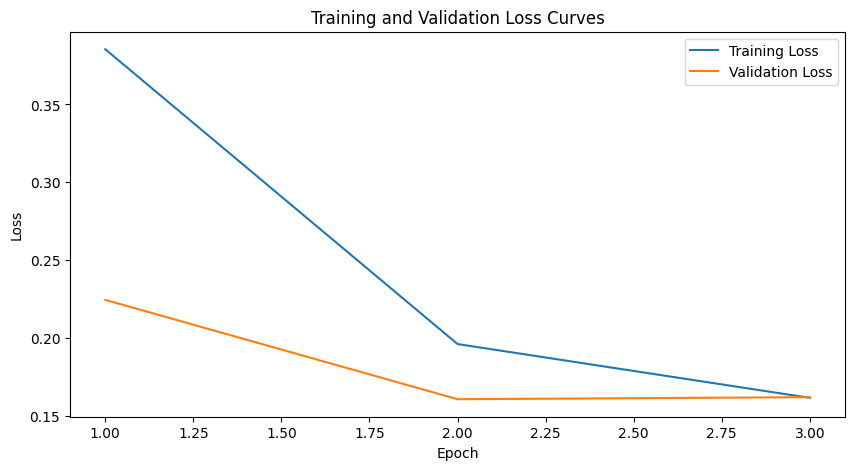

In [16]:
# Extract the training and validation losses from the log history
training_losses = []
validation_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        training_losses.append(log["loss"])
    if "eval_loss" in log:
        validation_losses.append(log["eval_loss"])
steps = list(range(1, len(training_losses) + 1))

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(steps, training_losses, label="Training Loss")
plt.plot(steps, validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Curves")
plt.show()
